# Set up

In [1]:
import torch
import gpytorch
import pandas as pd
import numpy as np
import tqdm as tqdm
from linear_operator import settings

import pyro
import math
import pickle
import time
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import pyro.distributions as dist
from pyro.infer import MCMC, NUTS
import arviz as az
import seaborn as sns

import os
import scipy.stats as stats

In [2]:
import GP_functions.Loss_function as Loss_function
import GP_functions.bound as bound
import GP_functions.Estimation as Estimation
import GP_functions.Training as Training
import GP_functions.Prediction as Prediction
import GP_functions.GP_models as GP_models
import GP_functions.Tools as Tools
import GP_functions.FeatureE as FeatureE

In [3]:
Device = 'cpu'

# Data

In [4]:
X_train = pd.read_csv('Data/X_train.csv', header=None, delimiter=',').values
X_test = pd.read_csv('Data/X_test.csv', header=None, delimiter=',').values

# Y_train_8 = pd.read_csv('Data/Y_train_8.csv', header=None, delimiter=',').values
# Y_test_8 = pd.read_csv('Data/Y_test_8.csv', header=None, delimiter=',').values

Y_train_21 = pd.read_csv('Data/Y_train_std_21.csv', header=None, delimiter=',').values
Y_test_21 = pd.read_csv('Data/Y_test_std_21.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('Data/Y_train_std.csv', header=None, delimiter=',').values
Y_test_std = pd.read_csv('Data/Y_test_std.csv', header=None, delimiter=',').values

In [5]:
train_x = torch.tensor(X_train, dtype=torch.float32)
test_x = torch.tensor(X_test, dtype=torch.float32)

# train_y_8 = torch.tensor(Y_train_8, dtype=torch.float32)
# test_y_8 = torch.tensor(Y_test_8, dtype=torch.float32)

train_y_21 = torch.tensor(Y_train_21, dtype=torch.float32)
test_y_21 = torch.tensor(Y_test_21, dtype=torch.float32)

train_y = torch.tensor(Y_train_std, dtype=torch.float32)
test_y = torch.tensor(Y_test_std, dtype=torch.float32)

# Emulator

## MVGP

In [6]:
MVGP_models, MVGP_likelihoods = Training.train_full_MultitaskVGP(train_x, train_y_21, covar_type = 'RQ',
                                                                 num_latents=20, num_inducing=100, 
                                                                 lr_hyper=0.05, lr_variational=0.1, num_iterations=5000, patience=50, device=Device)

 42%|████▏     | 2122/5000 [14:37<19:49,  2.42it/s, loss=-20.7]


# MCMC

In [7]:
row_idx = 0

input_point = test_y_21[row_idx,:]
local_train_x, local_train_y = Tools.find_k_nearest_neighbors_CPU(input_point, train_x, train_y_21, k = 100)

bounds = bound.get_bounds(local_train_x)

## priori is Uniform(min, max)

In [8]:
def run_mcmc_Uniform(Pre_function, Models, Likelihoods, row_idx, test_y, bounds, num_sampling=2000, warmup_step=1000, num_chains=1):
    test_y = test_y.to(dtype=torch.float32)
    bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]
    
    def model():

        params = []
        for i, (min_val, max_val) in enumerate(bounds):
            param_i = pyro.sample(f'param_{i}', dist.Uniform(min_val, max_val))
            params.append(param_i)
        
        theta = torch.stack(params)

        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        y_obs = test_y[row_idx, :]
        pyro.sample('obs', gp_pred, obs=y_obs)

    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains)
    mcmc.run()

    return mcmc

In [9]:
mcmc_result_1 = run_mcmc_Uniform(Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, row_idx, test_y_21, bounds, 
                                            num_sampling = 1200, warmup_step = 300, num_chains=1)



Sample: 100%|██████████| 1500/1500 [16:04,  1.55it/s, step size=2.01e-01, acc. prob=0.943]


In [10]:
samples_1 = mcmc_result_1.get_samples()

torch.save(samples_1, "mcmc_samples_1.pt")

# loaded_samples = torch.load("mcmc_samples_1.pt")

/home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


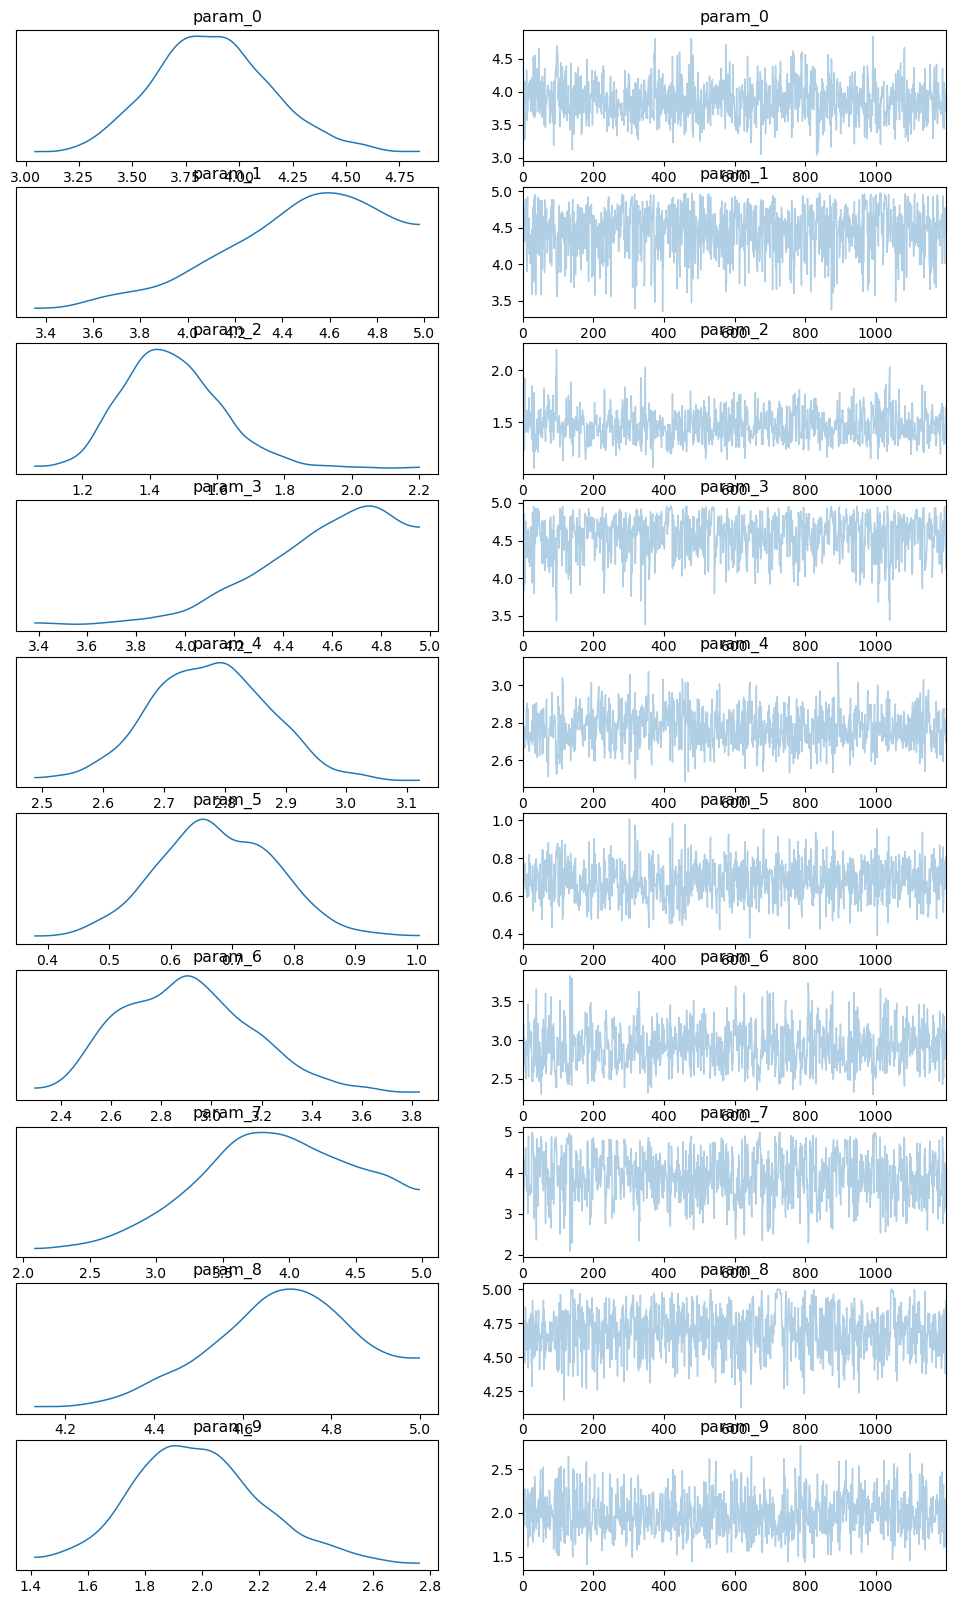

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
param_0  3.878  0.287     3.307      4.437      0.011    0.008     700.0   
param_1  4.463  0.333     3.809      4.980      0.012    0.009     653.0   
param_2  1.465  0.144     1.187      1.737      0.006    0.004     662.0   
param_3  4.569  0.266     4.084      4.958      0.011    0.008     568.0   
param_4  2.776  0.097     2.589      2.960      0.004    0.003     664.0   
param_5  0.676  0.097     0.481      0.857      0.004    0.003     703.0   
param_6  2.909  0.264     2.464      3.455      0.011    0.008     556.0   
param_7  3.914  0.577     2.864      4.909      0.025    0.018     490.0   
param_8  4.693  0.159     4.409      4.999      0.007    0.005     427.0   
param_9  1.986  0.224     1.555      2.448      0.007    0.005     942.0   

         ess_tail  r_hat  
param_0     665.0    NaN  
param_1     618.0    NaN  
param_2     649.0    NaN  
param_3     488.0    NaN  
param_4     912.0    NaN  
p

In [20]:
idata = az.from_pyro(mcmc_result_1)

summary = az.summary(idata, hdi_prob=0.95)

az.plot_trace(idata)
plt.show()
print(summary)

In [29]:
test_x[0]

tensor([3.6700, 4.8642, 1.4330, 4.7406, 2.8699, 0.6171, 3.0394, 3.4495, 4.7810,
        1.8129])

## priori is Uniform(0.1, 5)

In [11]:
def run_mcmc_Uniform_2(Pre_function, Models, Likelihoods, row_idx, test_y, bounds, num_sampling=2000, warmup_step=1000, num_chains=1):
    test_y = test_y.to(dtype=torch.float32)
    bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]
    
    def model():

        params = []
        for i, (min_val, max_val) in enumerate(bounds):
            param_i = pyro.sample(f'param_{i}', dist.Uniform(0.1, 5))
            params.append(param_i)
        
        theta = torch.stack(params)

        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        y_obs = test_y[row_idx, :]
        pyro.sample('obs', gp_pred, obs=y_obs)

    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains)
    mcmc.run()

    return mcmc

In [12]:
import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()
mcmc_result_2 = run_mcmc_Uniform_2(Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, row_idx, test_y_21, bounds, 
                                            num_sampling = 1200, warmup_step = 300, num_chains=1)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats()


Sample: 100%|██████████| 1500/1500 [24:08,  1.04it/s, step size=2.10e-01, acc. prob=0.950]

         919318834 function calls (842393515 primitive calls) in 1448.459 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000 1448.548  724.274 /home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        2    0.000    0.000 1448.548  724.274 {built-in method builtins.exec}
        1    0.000    0.000 1448.548 1448.548 /tmp/ipykernel_2460348/3701999863.py:1(run_mcmc_Uniform_2)
 113539/1    0.297    0.000 1448.548 1448.548 /home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/pyro/poutine/messenger.py:25(_context_wrap)
        1    0.006    0.006 1448.548 1448.548 /home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:531(run)
     1203    0.002    0.000 1448.540    1.204 /home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/pyro/infer/mcmc/api.py:213(run)
     1203 

In [13]:
samples_2 = mcmc_result_2.get_samples()

torch.save(samples_2, "mcmc_samples_2.pt")

# loaded_samples = torch.load("mcmc_samples_1.pt")

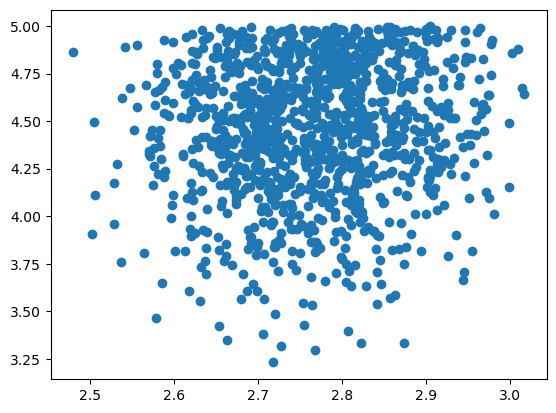

In [35]:
plt.scatter(samples_2['param_4'],samples_2['param_1'])

/home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


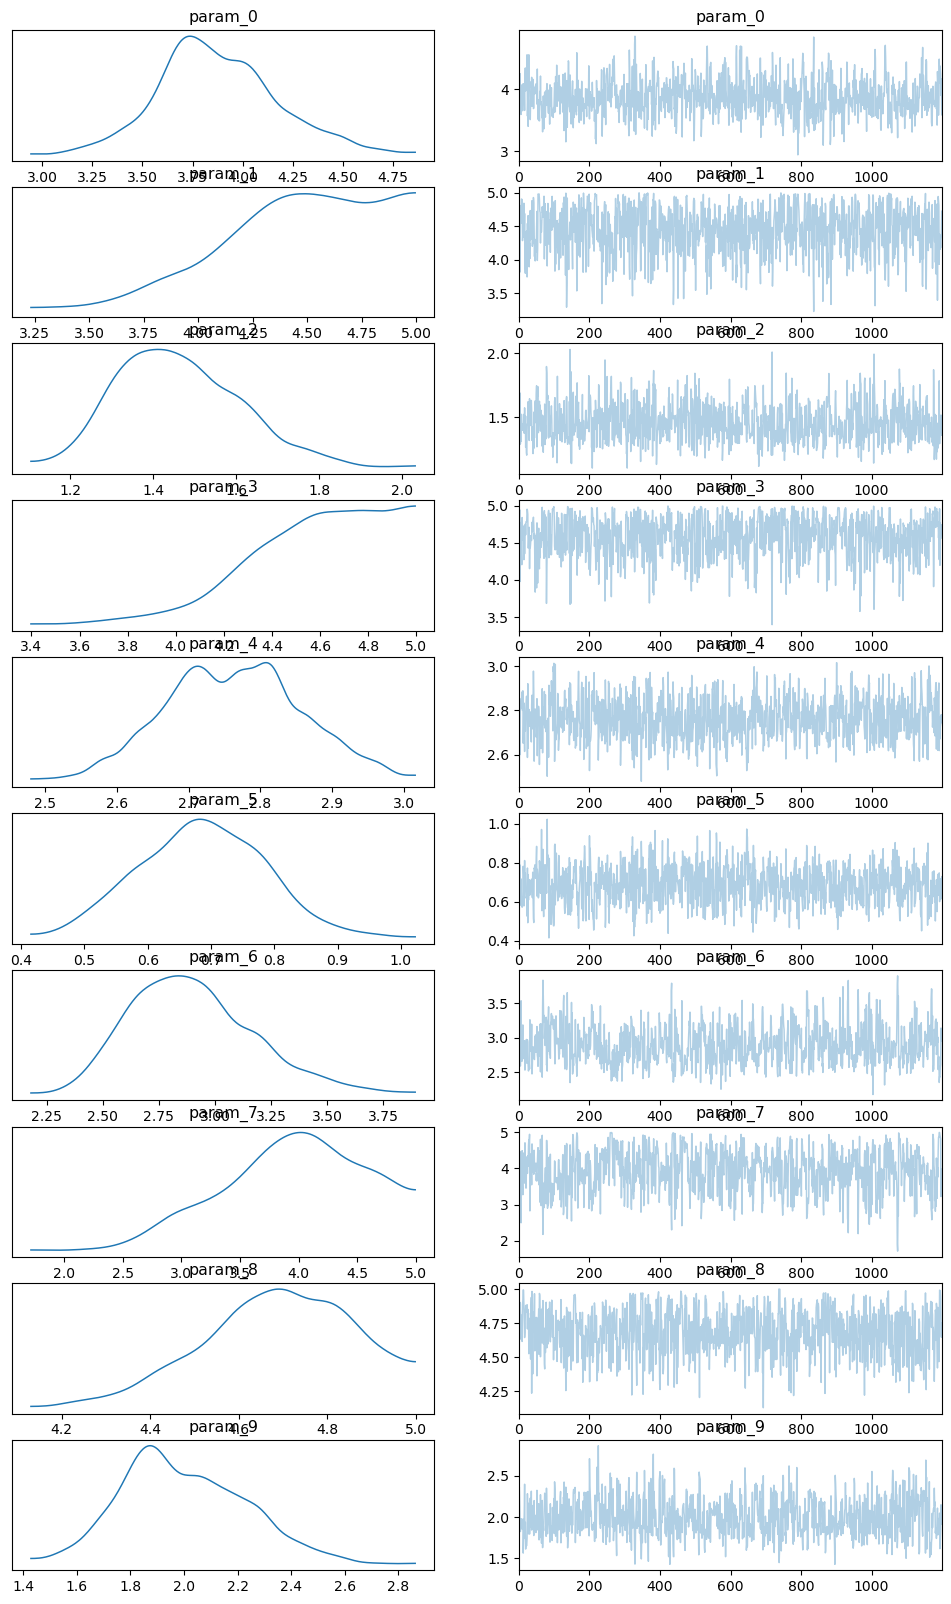

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
param_0  3.878  0.297     3.345      4.524      0.012    0.009     584.0   
param_1  4.455  0.356     3.813      4.997      0.013    0.009     643.0   
param_2  1.463  0.149     1.197      1.762      0.005    0.004     813.0   
param_3  4.583  0.280     4.079      4.997      0.011    0.008     621.0   
param_4  2.764  0.095     2.577      2.946      0.003    0.002     764.0   
param_5  0.685  0.098     0.489      0.865      0.004    0.003     749.0   
param_6  2.900  0.277     2.418      3.464      0.014    0.010     390.0   
param_7  3.946  0.592     2.895      4.996      0.029    0.021     363.0   
param_8  4.686  0.165     4.385      4.985      0.006    0.004     644.0   
param_9  1.999  0.231     1.596      2.485      0.009    0.007     666.0   

         ess_tail  r_hat  
param_0     629.0    NaN  
param_1     395.0    NaN  
param_2     740.0    NaN  
param_3     609.0    NaN  
param_4     753.0    NaN  
p

In [21]:
idata = az.from_pyro(mcmc_result_2)

summary = az.summary(idata, hdi_prob=0.95)

az.plot_trace(idata)
plt.show()
print(summary)

In [14]:
def run_mcmc_Uniform_3(Pre_function, Models, Likelihoods, row_idx, test_y, bounds, num_sampling=2000, warmup_step=1000, num_chains=1):
    test_y = test_y.to(dtype=torch.float32)
    bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]
    
    def model():

        params = []
        for i, (min_val, max_val) in enumerate(bounds):
            param_i = pyro.sample(f'param_{i}', dist.Uniform(0.1, 6))
            params.append(param_i)
        
        theta = torch.stack(params)

        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        y_obs = test_y[row_idx, :]
        pyro.sample('obs', gp_pred, obs=y_obs)

    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains)
    mcmc.run()

    return mcmc

In [15]:
mcmc_result_3 = run_mcmc_Uniform_3(Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, row_idx, test_y_21, bounds, 
                                            num_sampling = 1200, warmup_step = 300, num_chains=1)



Sample: 100%|██████████| 1500/1500 [16:04,  1.56it/s, step size=1.80e-01, acc. prob=0.119]


In [16]:
samples_3 = mcmc_result_3.get_samples()

torch.save(samples_3, "mcmc_samples_3.pt")

# loaded_samples = torch.load("mcmc_samples_1.pt")

/home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


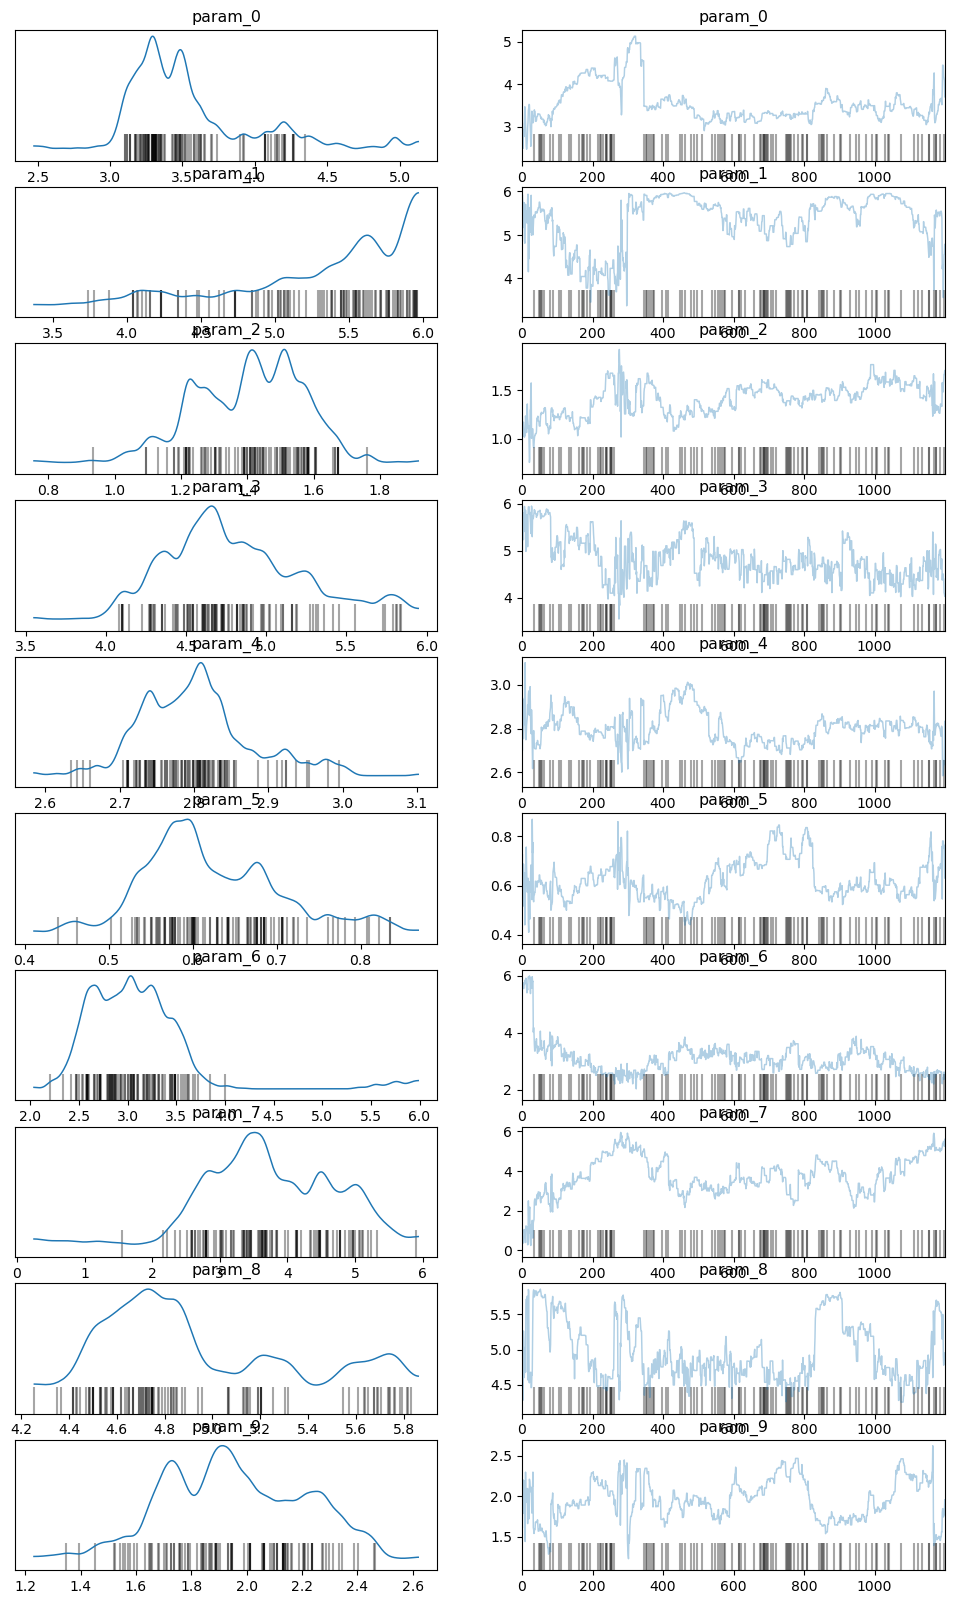

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
param_0  3.548  0.445     3.024      4.619      0.156    0.115      11.0   
param_1  5.318  0.587     4.069      5.963      0.192    0.140      10.0   
param_2  1.404  0.161     1.095      1.673      0.093    0.074       3.0   
param_3  4.814  0.433     4.094      5.765      0.202    0.158       6.0   
param_4  2.802  0.074     2.690      2.985      0.029    0.021       8.0   
param_5  0.623  0.081     0.506      0.823      0.035    0.027       5.0   
param_6  3.085  0.569     2.317      3.772      0.152    0.110      13.0   
param_7  3.731  0.975     2.264      5.600      0.285    0.209      12.0   
param_8  4.962  0.416     4.448      5.835      0.098    0.071      21.0   
param_9  1.957  0.248     1.561      2.465      0.058    0.042      19.0   

         ess_tail  r_hat  
param_0      22.0    NaN  
param_1      29.0    NaN  
param_2      19.0    NaN  
param_3      11.0    NaN  
param_4      26.0    NaN  
p

In [22]:
idata = az.from_pyro(mcmc_result_3)

summary = az.summary(idata, hdi_prob=0.95)

az.plot_trace(idata)
plt.show()
print(summary)

## priori is Normal(mean, std) from local data

In [24]:
def run_mcmc_Normal(Pre_function, Models, Likelihoods, row_idx, test_y, local_train_x, num_sampling=2000, warmup_step=1000, num_chains=1):
    def model():
        params = []
        
        for i in range(local_train_x.shape[1]):
            mean = local_train_x[:, i].mean()
            std = local_train_x[:, i].std()
            # mean, std = stats.norm.fit(local_train_x[:, i])
            param_i = pyro.sample(f'param_{i}', dist.Normal(mean, std))
            params.append(param_i)
        
        theta = torch.stack(params)
        
        gp_pred = Pre_function(Models, Likelihoods, theta.unsqueeze(0))

        y_obs = test_y[row_idx, :]
        pyro.sample('obs', gp_pred, obs=y_obs)

    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_sampling, warmup_steps=warmup_step, num_chains=num_chains)
    mcmc.run()

    # posterior_samples = mcmc.get_samples()

    # idata = az.from_pyro(mcmc)

    # summary = az.summary(idata, hdi_prob=0.95)
    
    return mcmc


In [28]:
for i in range(local_train_x.shape[1]):
    mean = local_train_x[:, i].mean()
    print(mean)
    td = local_train_x[:, i].std()
    print(td)

tensor(3.6925)
tensor(0.8921)
tensor(3.2827)
tensor(1.2535)
tensor(2.9946)
tensor(1.1098)
tensor(2.7026)
tensor(1.3739)
tensor(1.8334)
tensor(0.7250)
tensor(2.3930)
tensor(1.2699)
tensor(3.5755)
tensor(0.9525)
tensor(2.8919)
tensor(1.3704)
tensor(3.9304)
tensor(0.7213)
tensor(3.1285)
tensor(1.2005)


In [25]:
mcmc_result_4 = run_mcmc_Normal(Prediction.preds_distribution, MVGP_models, MVGP_likelihoods, row_idx, test_y_21, local_train_x, 
                                            num_sampling = 1200, warmup_step = 300, num_chains=1)



Sample: 100%|██████████| 1500/1500 [07:43,  3.24it/s, step size=4.54e-01, acc. prob=0.921]


In [26]:
samples_4 = mcmc_result_4.get_samples()

torch.save(samples_4, "mcmc_samples_4.pt")

# loaded_samples = torch.load("mcmc_samples_1.pt")

/home/pgrad1/2633042r/miniconda3/envs/GT/lib/python3.10/site-packages/arviz/data/io_pyro.py:158: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 1200), minimum_shape: (chains=2, draws=4)


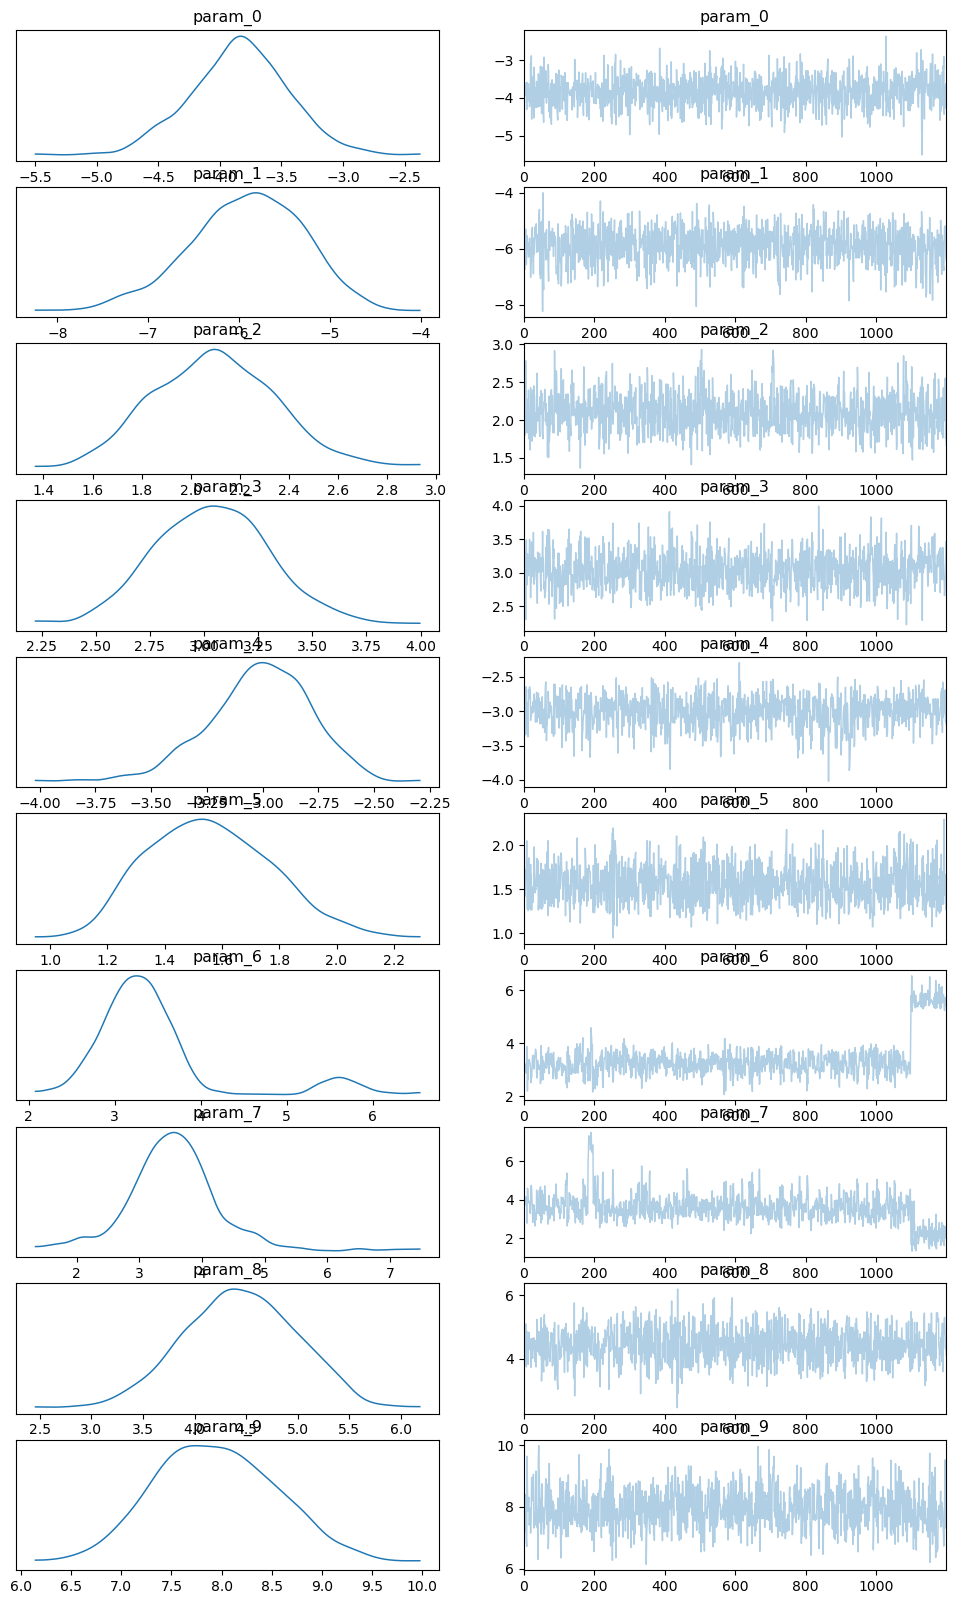

          mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
param_0 -3.840  0.391    -4.594     -3.083      0.011    0.008    1340.0   
param_1 -5.916  0.625    -7.184     -4.719      0.019    0.014    1160.0   
param_2  2.100  0.251     1.604      2.570      0.009    0.006     886.0   
param_3  3.037  0.267     2.500      3.539      0.009    0.006     924.0   
param_4 -3.014  0.226    -3.433     -2.587      0.008    0.006     809.0   
param_5  1.558  0.213     1.164      1.963      0.006    0.005    1186.0   
param_6  3.440  0.763     2.441      5.659      0.266    0.206      29.0   
param_7  3.551  0.774     1.936      5.004      0.200    0.145      18.0   
param_8  4.440  0.536     3.475      5.490      0.017    0.012    1027.0   
param_9  7.948  0.632     6.860      9.327      0.023    0.016     784.0   

         ess_tail  r_hat  
param_0     894.0    NaN  
param_1     789.0    NaN  
param_2     617.0    NaN  
param_3     937.0    NaN  
param_4     772.0    NaN  
p

In [27]:
idata = az.from_pyro(mcmc_result_4)

summary = az.summary(idata, hdi_prob=0.95)

az.plot_trace(idata)
plt.show()
print(summary)

In [ ]:
import torch
import pyro
import pyro.distributions as dist
from tqdm import tqdm

def run_mcmc_MH(Pre_function, Models, Likelihoods, row_idx, test_y, bounds, 
                num_sampling=2000, warmup_step=1000, proposal_std=0.1, num_chains=1):


    test_y = test_y.to(dtype=torch.float32)
    bounds = [(torch.tensor(b[0], dtype=torch.float32), torch.tensor(b[1], dtype=torch.float32)) for b in bounds]

    theta_dim = len(bounds)
    current_theta = torch.tensor([torch.rand(1).item() * (b[1] - b[0]) + b[0] for b in bounds], 
                                 dtype=torch.float32, requires_grad=False)
    
    samples = []
    current_log_prob = None

    with torch.no_grad():
        gp_pred = Pre_function(Models, Likelihoods, current_theta.unsqueeze(0))
        y_obs = test_y[row_idx, :]
        likelihood = torch.exp(-torch.norm(gp_pred - y_obs, p=2))
        prior = 1.0
        current_log_prob = torch.log(likelihood * prior)

    # Metropolis-Hastings 采样过程
    for step in tqdm(range(num_sampling)):
        # 生成新样本：从正态提议分布 q(x' | x) 采样
        proposal = current_theta + proposal_std * torch.randn_like(current_theta)

        # 约束参数在边界范围内
        for i in range(theta_dim):
            proposal[i] = torch.clamp(proposal[i], bounds[i][0], bounds[i][1])

        # 计算新样本的对数后验
        with torch.no_grad():
            gp_pred = Pre_function(Models, Likelihoods, proposal.unsqueeze(0))
            likelihood = torch.exp(-torch.norm(gp_pred - y_obs, p=2))
            new_log_prob = torch.log(likelihood * prior)

        # 计算接受率 alpha
        alpha = torch.exp(new_log_prob - current_log_prob)  # 计算接受比率
        acceptance_prob = torch.min(torch.tensor(1.0), alpha)  # 确保接受概率不超过 1

        # 采样是否接受
        if torch.rand(1).item() < acceptance_prob:
            current_theta = proposal.clone()
            current_log_prob = new_log_prob  # 更新后验值
        
        # 记录样本（丢弃 warmup 期间的采样）
        if step >= warmup_step:
            samples.append(current_theta.clone())

    return torch.stack(samples)  # 返回采样参数的 Tensor


# END